In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time, os, copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torchvision import datasets, transforms, models, utils
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, random_split

import pytorch_model_prune.prune as prune_model
import pytorch_model_prune.FLOP as FLOP

from sklearn.metrics import accuracy_score, recall_score, f1_score

In [2]:
# Dataset dir
data_dir = 'Monkeypox Skin Image Dataset/'
train_dir = 'Monkeypox Skin Image Dataset/train'
val_dir = 'Monkeypox Skin Image Dataset/val'

# Split 7:3
split_ratio = 0.7 

In [3]:
# Dataset transform dan augmentation
transform = {
    'train':transforms.Compose([
        transforms.Resize(232,interpolation=InterpolationMode.BILINEAR),
        transforms.RandomResizedCrop(232),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val':transforms.Compose([
        transforms.Resize(232,interpolation=InterpolationMode.BILINEAR),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

dataset = {x: datasets.ImageFolder(root=os.path.join(data_dir,x), transform=transform[x])
            for x in ['train', 'val']}

# Batching data loader
batch_size = 60
dataloaders = {x: torch.utils.data.DataLoader(dataset[x], batch_size= batch_size, shuffle=True)
              for x in ['train', 'val']}
dataset_size = {x: len(dataset[x]) for x in ['train', 'val']}
class_names = dataset['train'].classes
num_classes = len(dataset['train'].classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("Num Classes", num_classes)
print("Class names:", class_names)
num = {x:print(f"{x} data {dataset_size[x]}") for x in ['train','val']}

Num Classes 4
Class names: ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']
train data 537
val data 233


In [4]:
# Load the saved state dictionary
model = torch.load('training.pth')

# Gunakan GPU processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
# Validasi model
all_predictions = []
all_labels = []
model.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Buat array
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Hitung metrics uji
accuracy = accuracy_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9055793991416309
Recall: 0.9055793991416309
F1 Score: 0.9055391271587003


In [6]:
print(f"Unpruned Model Size: {sum(p.numel() for p in model.parameters()):,.0f} parameter")
print(f"FLOP: {FLOP.count_model_param_flops(model, 224):,.0f}")

Unpruned Model Size: 23,516,228 parameter
FLOP: 8,207,931,904


In [7]:
print(f"Unpruned Model Size: {os.path.getsize('training.pth')/(1024 * 1024):.2f} MB")

Unpruned Model Size: 90.04 MB


In [8]:
def get_cut_off(module, prune_amt):
    layer_eval_list = []
    for layer in module:
        layer_eval_list.append(prune_model.layer_eval(layer))

    layer_eval_list.sort()
    cut_off = layer_eval_list[int(prune_amt * len(layer_eval_list))]
    return cut_off

def apply_pruning_to_layers(model, layers, prune_amt):
    for layer_name in layers:
        if layer_name == 'conv1':
            layer = model._modules[layer_name]
            cut_off = get_cut_off(layer.weight, prune_amt)
            model._modules[layer_name] = prune_model.pruned_conv2d(layer, cut_off)
        else:
            l = layer_name.split('.')
            layer = model._modules[l[0]]._modules[l[1]]._modules[l[2]]
            cut_off = get_cut_off(layer.weight, prune_amt)
            model._modules[l[0]]._modules[l[1]]._modules[l[2]] = prune_model.pruned_conv2d(layer, cut_off)
        print(f'Pruned layer {layer_name}')

all_layers_to_prune = [
    'conv1',
    'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3',
    'layer1.1.conv1', 'layer1.1.conv2', 'layer1.1.conv3',
    'layer1.2.conv1', 'layer1.2.conv2', 'layer1.2.conv3',
    'layer2.0.conv1', 'layer2.0.conv2', 'layer2.0.conv3',
    'layer2.1.conv1', 'layer2.1.conv2', 'layer2.1.conv3',
    'layer2.2.conv1', 'layer2.2.conv2', 'layer2.2.conv3',
    'layer2.3.conv1', 'layer2.3.conv2', 'layer2.3.conv3',
    'layer3.0.conv1', 'layer3.0.conv2', 'layer3.0.conv3',
    'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3',
    'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3',
    'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3',
    'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3',
    'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3',
    'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3',
    'layer4.1.conv1', 'layer4.1.conv2', 'layer4.1.conv3',
    'layer4.2.conv1', 'layer4.2.conv2', 'layer4.2.conv3',
]

apply_pruning_to_layers(model, all_layers_to_prune, 0.40)

Pruned layer conv1
Pruned layer layer1.0.conv1
Pruned layer layer1.0.conv2
Pruned layer layer1.0.conv3
Pruned layer layer1.1.conv1
Pruned layer layer1.1.conv2
Pruned layer layer1.1.conv3
Pruned layer layer1.2.conv1
Pruned layer layer1.2.conv2
Pruned layer layer1.2.conv3
Pruned layer layer2.0.conv1
Pruned layer layer2.0.conv2
Pruned layer layer2.0.conv3
Pruned layer layer2.1.conv1
Pruned layer layer2.1.conv2
Pruned layer layer2.1.conv3
Pruned layer layer2.2.conv1
Pruned layer layer2.2.conv2
Pruned layer layer2.2.conv3
Pruned layer layer2.3.conv1
Pruned layer layer2.3.conv2
Pruned layer layer2.3.conv3
Pruned layer layer3.0.conv1
Pruned layer layer3.0.conv2
Pruned layer layer3.0.conv3
Pruned layer layer3.1.conv1
Pruned layer layer3.1.conv2
Pruned layer layer3.1.conv3
Pruned layer layer3.2.conv1
Pruned layer layer3.2.conv2
Pruned layer layer3.2.conv3
Pruned layer layer3.3.conv1
Pruned layer layer3.3.conv2
Pruned layer layer3.3.conv3
Pruned layer layer3.4.conv1
Pruned layer layer3.4.conv2
P

In [9]:
model

ResNet(
  (conv1): pruned_conv2d(
    (new_conv2d): Conv2d(3, 38, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (zero_padding): zero_padding()
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): pruned_conv2d(
        (new_conv2d): Conv2d(64, 38, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (zero_padding): zero_padding()
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): pruned_conv2d(
        (new_conv2d): Conv2d(64, 38, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (zero_padding): zero_padding()
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): pruned_conv2d(
        (new_conv2d): Conv2

In [10]:
# Validasi model
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Buat array
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Hitung metrics uji
accuracy = accuracy_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.3776824034334764
Recall: 0.3776824034334764
F1 Score: 0.2070782025055821


In [11]:
print(model.state_dict().keys())

odict_keys(['conv1.new_conv2d.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.new_conv2d.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.new_conv2d.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.new_conv2d.weight', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.downsample.0.weight', 'layer1.0.downsample.1.weight', 'layer1.0.downsample.1.bias', 'layer1.0.downsample.1.running_mean', 'layer1.0.downsample.1.running_var', 'layer1.0.downsample.1.num_batches_tracked', 'layer1.1.conv1.new_conv2d.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var',

In [12]:
torch.save(model.state_dict(), 'tesprune2_training.pth')

In [13]:
print(f"Pruned Model Size: {sum(p.numel() for p in model.parameters()):,.0f} parameter")
print(f"FLOP: {FLOP.count_model_param_flops(model, 224):,.0f}")

Pruned Model Size: 15,218,198 parameter
FLOP: 5,203,091,968


In [14]:
print(f"Pruned Model Size: {os.path.getsize('tesprune2_training.pth')/(1024 * 1024):.2f} MB")

Pruned Model Size: 58.36 MB


In [15]:
def train_model(model, criterion, optimizer, scheduler, batch_size, num_epochs):
    since = time.time()
    
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc= list()
    valid_acc= list()
    train_loss= list()
    val_loss= list()

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Setiap epoch diuji train val
        for phase in ['train', 'val']:
            if phase == 'train':
                if epoch!=0:
                    scheduler.step()
                model.train()  # Set model ke mode train
            else:
                model.eval()   # Set model ke mode evaluate

            running_loss = 0.0
            running_corrects = 0
            running_prec= 0.0
            running_rec = 0.0
            running_f1  = 0.0

            # Iterasi data
            cur_batch_ind= 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # set zero gradient parameter
                optimizer.zero_grad()

                # forward
                # optimasi model fase train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistik
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                cur_acc= torch.sum(preds == labels.data).double()/batch_size
                cur_batch_ind +=1
                print("\npreds:", preds)
                print("label:", labels.data)
                print("%d-th epoch, %d-th batch (size=%d), %s acc= %.3f \n" %(epoch+1, cur_batch_ind, len(labels), phase, cur_acc ))
                
                if phase=='train':
                    train_acc.append(cur_acc)
                else:
                    valid_acc.append(cur_acc)
                
            epoch_loss= running_loss / dataset_size[phase]
            epoch_acc = running_corrects.double() / dataset_size[phase]
            if phase=='train':
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f} \n\n'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_epoch= epoch
                best_model = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc= %.3f at Epoch: %d' %(best_acc,best_epoch+1) )

    # load bobot terbaik
    model.load_state_dict(best_model)
    return model, train_acc, valid_acc, train_loss, val_loss

In [16]:
# Loss function dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# LR scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# Gunakan GPU processing
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Jumlah epoch
num_epochs = 45

model, train_acc, valid_acc, train_loss, val_loss=train_model(model, criterion, optimizer, scheduler, batch_size, num_epochs)

Epoch 1/45
----------

preds: tensor([2, 2, 1, 0, 3, 3, 2, 1, 3, 3, 3, 2, 2, 2, 1, 3, 2, 2, 1, 3, 2, 0, 3, 2,
        3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 2, 3, 3, 3, 2, 1, 2, 2, 3, 3, 3, 3, 0, 2,
        0, 2, 2, 2, 2, 2, 2, 0, 2, 3, 2, 3], device='cuda:0')
label: tensor([3, 0, 1, 3, 1, 3, 2, 0, 0, 3, 3, 3, 3, 3, 2, 2, 0, 2, 3, 1, 0, 1, 0, 0,
        3, 0, 3, 3, 2, 1, 2, 2, 0, 3, 2, 3, 1, 2, 0, 2, 0, 2, 3, 3, 3, 3, 0, 2,
        2, 2, 2, 0, 3, 2, 2, 0, 3, 2, 0, 2], device='cuda:0')
1-th epoch, 1-th batch (size=60), train acc= 0.383 


preds: tensor([2, 3, 2, 3, 3, 2, 2, 2, 2, 0, 3, 2, 1, 3, 0, 3, 1, 3, 3, 0, 3, 2, 3, 1,
        0, 3, 2, 0, 3, 2, 2, 1, 2, 2, 3, 3, 0, 3, 3, 1, 2, 3, 3, 3, 1, 3, 2, 2,
        2, 0, 3, 1, 2, 0, 3, 3, 3, 2, 3, 3], device='cuda:0')
label: tensor([3, 3, 2, 3, 2, 0, 3, 2, 2, 2, 3, 2, 3, 0, 0, 3, 3, 3, 3, 1, 3, 2, 2, 3,
        2, 0, 2, 3, 2, 1, 2, 3, 0, 2, 2, 3, 3, 3, 3, 1, 2, 2, 3, 3, 2, 0, 1, 2,
        2, 0, 3, 2, 3, 0, 3, 3, 3, 2, 2, 3], device='cuda:0')
1-th ep

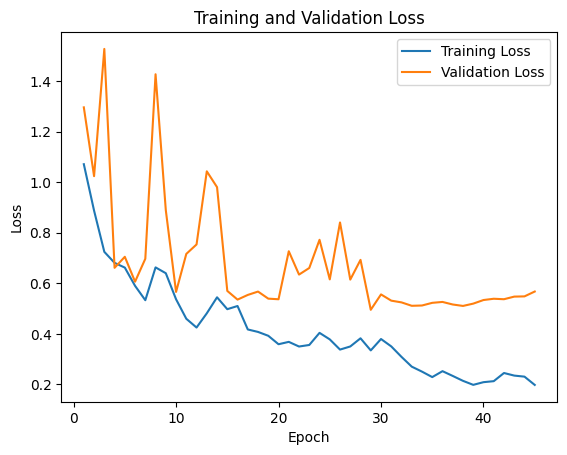

In [17]:
# Plot Loss
plt.plot(range(1, int(num_epochs) + 1), train_loss, label='Training Loss')
plt.plot(range(1, int(num_epochs) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('prune2-train-val-loss.png')
plt.show()

In [18]:
# Pindah cpu processing
train_acc = [acc.cpu() for acc in train_acc]
valid_acc = [acc.cpu() for acc in valid_acc]

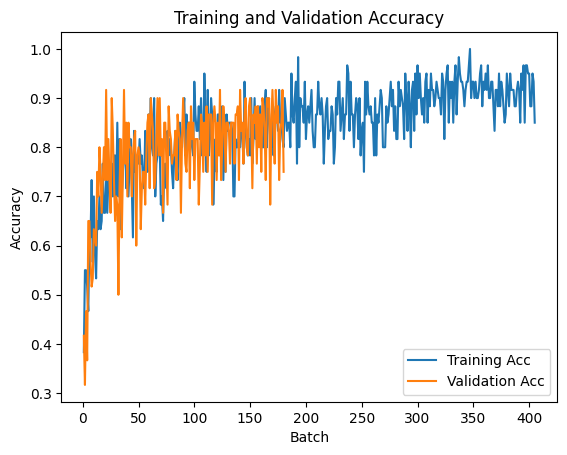

In [19]:
# Plot Acc
plt.plot(range(1, int(len(train_acc)) + 1), train_acc, label='Training Acc')
plt.plot(range(1, int(len(valid_acc)) + 1), valid_acc, label='Validation Acc')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('prune2-train-val-acc')
plt.show()

In [20]:
# Validasi model
all_predictions = []
all_labels = []
model.eval()

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Compute metrics
accuracy = accuracy_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Print or log the metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.871244635193133
Recall: 0.871244635193133
F1 Score: 0.8704147047622802


In [21]:
torch.save(model.state_dict(), 'tesprune2_training.pth')
print(f"Pruned Model Size: {sum(p.numel() for p in model.parameters()):,.0f} parameter")
print(f"FLOP: {FLOP.count_model_param_flops(model, 224):,.0f}")
print(f"Pruned Model Size: {os.path.getsize('tesprune2_training.pth')/(1024 * 1024):.2f} MB")

Pruned Model Size: 15,218,198 parameter
FLOP: 5,203,091,968
Pruned Model Size: 58.36 MB
